In [1]:
#import libraries
# import tensorflow as tf
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image

# torch.__version__

# device = 'cuda' if torch.cuda.is_available() else 'cpu'

import matplotlib.pyplot as plt
import numpy as np

#Task2

Files already downloaded and verified


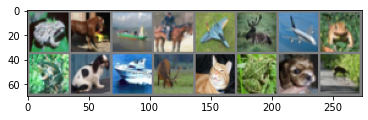

 frog horse  ship horse plane  deer plane  frog  frog   dog  ship  deer   cat  frog   dog  deer


In [2]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## cifar-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


batch_size = 16
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform= transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [3]:
#implement DenseNet architecture into image classification tutorial

import torch
import torch.nn as nn
import torch.nn.functional as F

class Dense_Layer(nn.Module):
    def __init__(self, n_in, n_out):
        super(Dense_Layer, self).__init__()
        self.bn = nn.BatchNorm2d(n_in)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(n_in, n_out, kernel_size=3, stride=1, padding=1, bias=False)
    def forward(self,x):
        out = self.conv(self.relu(self.bn(x)))
        x = torch.cat([x,out],1)
        return x

class Transition_Layer(nn.Sequential):
    def __init__(self, n_in, n_out):
        super(Transition_Layer, self).__init__()
        self.bn = nn.BatchNorm2d(n_in)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(n_in, n_out,kernel_size=1,stride=1,padding = 0,bias=0)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        x = self.pool(self.conv(self.relu(self.bn(x))))
        return x

class Dense_Block(nn.Module):
    def __init__(self, n_in, growth):
        super(Dense_Block, self).__init__()
        self.layer = self.dense_block(n_in, growth)
    def dense_block(self, n_in, growth):
        layers = []
        for i in range(0,4):
            layers.append(Dense_Layer(n_in + i*growth, growth))
        return nn.Sequential(*layers)
    def forward(self,x):
        return self.layer(x)

class DenseNet3(nn.Module):
    def __init__(self):
        super(DenseNet3, self).__init__()
        #initial convolution
        self.conv0 = nn.Conv2d(3, 6, kernel_size=3, stride = 1, padding=1, bias=False)
        
        #first denseblock
        self.dense1 = Dense_Block(n_in = 6, growth = 16)
        #note since there are 4 layers the output of denseblock will have 6 +4*16 channels
        self.trans1 = Transition_Layer(n_in = 70, n_out = 35)

        #second denseblock
        self.dense2 = Dense_Block(n_in = 35, growth = 16)
        #note since there are 4 layers the output of denseblock will have 35 + 4*16
        self.trans2 = Transition_Layer(n_in = 99, n_out=50)

        #third denseblock
        self.dense3 = Dense_Block(n_in=50,growth=16)

        #global average pooling, classifier
        self.bnend =  nn.BatchNorm2d(114)
        self.classifier = nn.Linear(114, 10)

    def forward(self,x):
        out = self.conv0(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.dense3(out)
        out = F.relu(self.bnend(out))
        out = F.adaptive_avg_pool2d(out, (1,1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)

        return out

In [4]:
def cutout(n, s, img):
    '''
    n = number of cutouts
    s = max length of a cutout side
    img = a tensor image of size (c, h, w)
    '''
        
    #get hieght and width of image
    h = img.size(1)
    w = img.size(2)

    # print(h,w)

    #initialize mask of same size as image
    mask = np.ones((h,w), np.float32)
    # print(mask)

    for j in range(n):

        #pick random location to be center of mask
        y = np.random.randint(h)
        x = np.random.randint(w)

        # print(y,x)

        #determine length of square mask
        l = np.random.randint(s)
        # l = s

        #apply shape to mask
        y_low = np.clip(y-l//2, 0, h)
        y_high = np.clip(y+l//2, 0, h)
        x_low = np.clip(x-l//2,0,w)
        x_high = np.clip(x+l//2,0,w)

        mask[y_low:y_high, x_low:x_high] = 0.


    # print(mask)
    #transform mask to tensor
    mask = torch.from_numpy(mask)
    mask = mask.expand_as(img)
    img = img*mask

    return img

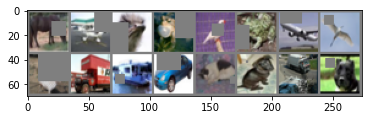

In [13]:
#print cutout images
image_ls = []

for i,x in enumerate(images):

    new_image = cutout(1,32,x)

    image_ls.append(new_image)
    

new_images = torch.stack(image_ls)

imshow(torchvision.utils.make_grid(new_images))

In [6]:
if __name__ == '__main__':
    ## cifar-10 dataset
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    batch_size = 20

    #get training set
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    #get test set
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    #declare classes
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # # example images
    # dataiter = iter(trainloader)
    # images, labels = dataiter.next()

    # im = Image.fromarray((torch.cat(images.split(1,0),3).squeeze()/2*255+.5*255).permute(1,2,0).numpy().astype('uint8'))
    # im.save("train_pt_images.jpg")
    # print('train_pt_images.jpg saved.')
    # print('Ground truth labels:' + ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


    ## densenet
    net = DenseNet3()
    ##print model architexture
    print("Model Architecture:")
    print("\n",net)


    ## loss and optimiser
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    #initialize empty vectors to store values
    train_accuracy = []
    train_losses =  []
    test_accuracy = []
    test_losses = []

    ## train
    for epoch in range(10):  # loop over the dataset multiple times

        print(f'Starting Epoch {epoch+1}')

        #train
        running_loss = 0.0
        # correct = 0.0
        # total = 0
        
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            #insert cutout algorithm into training
            cutouts = []
            for j,x in enumerate(inputs):
                new_image = cutout(1,16,x)
                cutouts.append(new_image)
            
            new_inputs = torch.stack(cutouts)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(new_inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            
            # _,predicted = outputs.max(1)
            # total += labels.size(0)
            # correct += predicted.eq(labels).sum().item()
        
        train_loss = running_loss/len(trainloader)
        # train_accu = 100.*correct/total

        # train_accuracy.append(train_accu)
        # train_losses.append(train_loss)

        print('Train Loss: %.3f'%(train_loss))

        #test
        running_loss = 0.0
        correct = 0.0
        total = 0

        #forward pass only
        with torch.no_grad():
            for i, data in enumerate(testloader,0):
                inputs, lables = data

                outputs = net(inputs)

                loss = criterion(outputs,labels)
                running_loss+=loss.item()

                _,predicted = outputs.max(1)
                total += labels.size(0)
                correct +=predicted.eq(labels).sum().item()

        test_loss = running_loss/len(testloader)
        test_accu = 100.*correct/total

        test_losses.append(test_loss)
        test_accuracy.append(test_accu)

        print('Test Loss: %.3f | Test Accuracy: %.3f'%(test_loss,test_accu),'%')
                    

    print('Training done.')

    # save trained model
    torch.save(net.state_dict(), 'saved_model.pt')
    print('Model saved.')

Files already downloaded and verified
Files already downloaded and verified
Model Architecture:

 DenseNet3(
  (conv0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Dense_Block(
    (layer): Sequential(
      (0): Dense_Layer(
        (bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): Dense_Layer(
        (bn): BatchNorm2d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv): Conv2d(22, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (2): Dense_Layer(
        (bn): BatchNorm2d(38, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv): Conv2d(38, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

KeyboardInterrupt: 